In [3]:
import numpy as np
import scipy
import scipy.optimize
from scipy.optimize import leastsq
from scipy.stats import norm
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import glob
from scipy.special import factorial
from scipy.stats import poisson
from scipy.interpolate import splrep, UnivariateSpline
import matplotlib.patches as patches
from scipy.stats import expon
import itertools

In [4]:
class Ion:
    # Written summer 2020
    # Email for questions: spedwards@ucdavis.edu
    def __init__(self, x0, y0, x1, y1, arrX, arrY, arrT, dT, N, threshold, debugPrinting=False):
        # input parameters:
            # x0, y0, x1, y1: limits of the region of interest
            # arrX, arrY: positional data of each photon event
            # arrT: timestamp of each photon event
            # dT: integration time
            # N: (for integration time method) minimum number of events for a time interval to be labelled bright
            # threshold: (for threshold method) line below which points are labelled bright

        # Constants
        self.x0 = x0
        self.y0 = y0
        self.x1 = x1
        self.y1 = y1
        self.dT = dT
        self.N = N
        self.threshold = threshold

        self.debugPrinting = debugPrinting

        # Internal arrays
        self.eventsForWindow = []
        self.brightRanges = []
        self.brightindex = []
        self.darkindex = []

        # Parts of the data inside the region of interest
        self.xROI = []
        self.yROI = []
        self.tofROI = []
        
        # Timestamps of photon events while the ion was bright/dark
        self.tofBright = []
        self.tofDark = []

        # Time between events 
        self.dtimeB = []
        self.dtimeD = []
        self.dtimeBout = []

        # Transition point/Quantum jump info
        self.transpts = []
        # DtB = dark to bright
        # BtD = bright to dark
        self.DtB = []
        self.BtD = []
        
        # 
        self.pretransition = []
        self.leadArray = []
        self.leadIndices = []
        self.outlierset = []
        self.hasoutliers = []

        # ensure that all the data is the same size and that the region is correctly defined
        assert len(arrX) == len(arrY) and len(arrY) == len(arrT)
        assert x0 <= x1 and y0 <= y1

        # setup functions
        self.GetEventsInRIO(arrX, arrY, arrT)
        self.plotImage(arrX, arrY)
        
  
    # helper functions
    def IsInRegion(self, x, y):
        # check if coords are in region of interest
        return self.x0 <= x and x <= self.x1 and self.y0 <= y and y <= self.y1
    def IncreaseIndex(self, idx):
        if idx[1] == 0:
            return [idx[0], 1]
        return [idx[0] + 1, 0]
    def changeN(self, n):
        self.N = n
    def changeThresh(self,thresh):
        self.threshold = thresh
    def DeleteTooOldEvents(self, t, prevHits, currInterval):
        while (len(prevHits) > 0 and (t - prevHits[0] > self.dT)):
            if (len(prevHits) == self.N):
                assert (currInterval != None)
                lastRange = None
                if len(self.brightRanges) > 0:
                    lastRange = self.brightRanges[-1]
                if (lastRange != None and lastRange[1] >= currInterval[0]):
                    self.brightRanges.pop()
                    currInterval[0] = lastRange[0]

                currInterval[1] = prevHits[-1]
                self.brightRanges.append(currInterval)
                if self.debugPrinting:
                    print("bright ranges append %s" % currInterval)

            oldElem = prevHits.pop(0)
            if self.debugPrinting:
                print("remove %s, length %s" % (oldElem, len(prevHits)))
    def GetIntervalBegin(self, x):
        res = self.dT * (int)(x / self.dT)
        return res
    def IsBright(self, t):
        # is the ion bright at this time?
        for i in self.brightRanges:
            if (i[0] <= t and t <= i[1]):
                return True
        return False
    def GetCountsForEvents(self, x, y, events, intersections=None):
        # counts events within each integration time
        
        # build arrays xyt with just events in region
        xi = []
        yi = []
        eventsi = []
        for i in range(len(x)):
            if (self.IsInRegion(x[i], y[i])):
                xi.append(x[i])
                yi.append(y[i])
                eventsi.append(events[i])

        # intersections stuff for later
        eventsi1 = []
        if intersections is not None:
            for i in range(len(eventsi)):
                for intersection in intersections:
                    if (intersection[0] <= eventsi[i] and eventsi[i] <= intersection[1]):
                        eventsi1.append(eventsi[i])
        else:
            eventsi1 = eventsi

        events = eventsi1

        res = []
        l = 0
        r = 0
        while l < len(events):
            intervalStart = self.GetIntervalBegin(events[l])
            r = l + 1
            while r < len(events) and events[r] - intervalStart <= self.dT:
                r += 1
            res.append(r - l)
            # print("append %s, interval begin %s, interval end %s, dT %s" % (r-l, intervalStart, events[r-1], self.dT))
            l = r

        sumTime = 0
        if intersections is not None:
            for intersection in intersections:
                sumTime += intersection[1] - intersection[0]
        else:
            sumTime = events[-1] - events[0]

        numberOfWindows = int(sumTime / self.dT)
        numberOfWindowsWithEvents = len(res)
        numberOfWindowsWithoutEvents = int(numberOfWindows - numberOfWindowsWithEvents)
        for i in range(numberOfWindowsWithoutEvents):
            res.append(0)

        return res
    def NoOutlierAvg(self):
        # finds average time between events in the bright state
        # with outliers excluded
        isoutlier = []
        hasoutlier = []

        iqr = scipy.stats.iqr(self.dtimeB)
        q1 = np.quantile(self.dtimeB, 0.25)
        q3 = np.quantile(self.dtimeB, 0.75)

        for i in range(len(self.dtimeB)):
            if self.dtimeB[i] > q3 + 1.5*iqr or self.dtimeB[i] < q1 - 1.5*iqr:
                isoutlier.append(self.dtimeB[i])
                hasoutlier.append(i)
        
        coolerdtimes = []
        for j in range(len(self.dtimeB)):
            if j not in hasoutlier:
                coolerdtimes.append(self.dtimeB[j])
        
        print("Standard Deviation of Bright State Transition Times w/o outliers:", np.std(coolerdtimes), "\n")
        self.dtimeBout = coolerdtimes.copy()
        return np.average(coolerdtimes)

    
    # data analysis
    def GetEventsInRIO(self, arrX, arrY, arrT):
        # isolates just points which fall inside the region of interest
        usethis = sorted(arrT)
        
        for i in range(len(arrX)):
            if self.IsInRegion(arrX[i], arrY[i]):
                self.xROI.append(arrX[i])
                self.yROI.append(arrY[i])
                self.tofROI.append(usethis[i])
    def idOutliers(self, data):
        # looks through the time between the last 5 events before each quantum jump
        # and marks outliers
        hitlist = []
        alloutlier = []
        for j in range(len(data)):
            isoutlier = []
            hasoutlier = []

            # definition of statistical outliers based on interquartile range
            iqr = scipy.stats.iqr(data[j])
            q1 = np.quantile(data[j], 0.25)
            q3 = np.quantile(data[j], 0.75)
            
            for i in range(len(self.leadArray)):
                if j < len(self.leadArray[i]):
                    if self.leadArray[i][j] > q3 + 1.5*iqr or self.leadArray[i][j] < q1 - 1.5*iqr:
                        isoutlier.append(self.leadArray[i][j])
                        hasoutlier.append(i)
            alloutlier.append(isoutlier.copy())
            hitlist.append(hasoutlier.copy())

        self.hasoutliers = hitlist.copy()
        self.outlierset = alloutlier.copy()
        return hitlist
    
    
    
    
    def transitions(self):
        # identifies points where quantum jumps happen
        # using list comprehension
        misscount = 0
        normallist = np.arange(len(self.tofROI))
        self.transpts.clear()
        for i in range(1, len(normallist)):
            if i not in self.brightindex:
                misscount = misscount + 1
                if misscount == 1:
                    self.transpts.append(i)
            if i in self.brightindex and misscount >= 1:
                misscount = 0
                self.transpts.append(i)
                
        # DtB = dark to bright
        # BtD = bright to dark
        self.DtB.clear()
        self.BtD.clear()
        for i in range(len(self.transpts)):
            if self.tofROI[self.transpts[i]] in self.tofBright:
                self.DtB.append(self.transpts[i])
            else:
                self.BtD.append(self.transpts[i])
    def leadup(self, setthresh=False, showdark=False,  outliers=True):
        # The main mechanism for averaging every leadup to a quantum jump
        # optional parameters: 
        #     setthresh: if True, sets a threshold above which points will be ignored
        #                threshold is set by the input parameters of the class
        #                but can be changed using changeThresh
        #     showdark: plots the average dark state time between photon events if True
        #     outliers: removes statistical outliers if false
        
        if setthresh==True and outliers==False:
            print("You picked two outlier removal options, put one back")
            return 0
        
        leadIndex = []

        # iterate through bright-to-dark transitions
        # and record the index of the five events before each transition
        # stopping if another transition is encountered
        for i in range(len(self.BtD)):
            holding = []
            if self.BtD[i] < 6:
                continue

            for j in range(1,6):
                if self.BtD[i]-j in self.transpts:
                    break
                holding.append(self.BtD[i] - j)
            leadIndex.append(holding.copy())
        self.leadIndices = leadIndex[:]
        
        # replace each item in that index with the value it represents
        if setthresh == True:
            for i in range(len(leadIndex)):
                for w in range(0, len(leadIndex[i])):
                    if leadIndex[i][w]-1 != len(self.tofROI) and (self.tofROI[leadIndex[i][w]] - self.tofROI[leadIndex[i][w]-1]) <= self.threshold:
                        leadIndex[i][w] = self.tofROI[leadIndex[i][w]] - self.tofROI[leadIndex[i][w]-1]
        else:
            for i in range(len(leadIndex)):
                for w in range(0, len(leadIndex[i])):
                    if leadIndex[i][w]-1 != len(self.tofROI):
                        leadIndex[i][w] = self.tofROI[leadIndex[i][w]] - self.tofROI[leadIndex[i][w]-1]
        
        self.leadArray = leadIndex.copy()
                        
        avgs = [[], [], [], [], []]
        for k in range(len(leadIndex)):
            for j in range(len(leadIndex[k])):
                avgs[j].append(leadIndex[k][j])
        self.pretransition = avgs.copy()
        
        if outliers==False:
            hitlist = list(itertools.chain.from_iterable(self.idOutliers(avgs)))
            temp = []
            for i in range(len(leadIndex)):
                if i not in hitlist:
                    temp.append(leadIndex[i])
            
            leadIndex = temp.copy()
        
        finalfive = []
        dev = []
        for j in range(len(avgs)):
            finalfive.append(np.average(avgs[j]))
            dev.append(np.std(avgs[j]))
        finalfive = np.flip(finalfive)
        print("Averages:", finalfive, "\n")
        dev = np.flip(dev)

        themscountinwords = np.arange(len(finalfive))
        errors = []
        for i in range(len(avgs)):
            errors.append(np.std(avgs[i])/np.sqrt(len(avgs[i])))
        errors = np.flip(errors)
        
        # Bright state average
        if outliers == False:
            overaverage = self.NoOutlierAvg()
            erroroveraverage = np.std(self.dtimeBout)/np.sqrt(len(self.dtimeBout))
            print("Average (no outliers)", overaverage, "\n")
        elif setthresh == True:
            self.dTimes(setthresh=True)
            overaverage = np.average(self.dtimeB)
            erroroveraverage = np.std(self.dtimeB)/np.sqrt(len(self.dtimeB))
            print("Standard Deviation w Ceiling:", np.std(self.dtimeB), "\n")
            print("Average (ceiling)", overaverage, "\n")
        else:
            overaverage = np.average(self.dtimeB)
            erroroveraverage = np.std(self.dtimeB)/np.sqrt(len(self.dtimeB))
            print("Standard Deviation with No Alteration:", np.std(self.dtimeB), "\n")
            print("Average (unaltered)", overaverage, "\n")
        
        # Dark state average
        darkavg = np.average(self.dtimeD)
        darkavgerr = np.std(self.dtimeD)/np.sqrt(len(self.dtimeD))
        
        # Plotting everything
        # The last photon before a bright->dark transition is represented by the rightmost point
        # The fifth-to-last is represented by the leftmost
        plt.errorbar(themscountinwords, finalfive, yerr=errors, fmt="bo")
        plt.axhline(overaverage, color='firebrick')
        plt.axhspan(overaverage-erroroveraverage, overaverage+erroroveraverage, alpha=0.5, color='lightpink')
        if showdark:
            plt.axhline(darkavg, color='darkblue')
            plt.axhspan(darkavg-darkavgerr, darkavg+darkavgerr, alpha=0.3, color='cornflowerblue')
        plt.title("Average picture of a Bright->Dark transition")
        plt.xlabel("Event #")
        plt.ylabel("Time since last event (ns)")
        plt.show()
    def timeSplit(self, arrX, arrY, arrT):
        # called during integration time method 
        # to record which counts happen in the bright state 
        # and which happen in the dark state
        self.tofBright.clear()
        self.tofDark.clear()
        for j in range(0, len(arrT)):
            if OneIon.IsBright(arrT[j]) and OneIon.IsInRegion(arrX[j], arrY[j]):
                self.tofBright.append(arrT[j])
            if OneIon.IsBright(arrT[j]) == False and OneIon.IsInRegion(arrX[j], arrY[j]):
                self.tofDark.append(arrT[j])
    def dTimes(self, setthresh=False):
        self.dtimeB.clear()
        self.dtimeD.clear()
        
        dtimes = []
        if setthresh == False:
            for i in range(1, len(self.tofROI)):
                dtimes.append(self.tofROI[i]-self.tofROI[i-1])
                if self.tofROI[i] in self.tofBright:
                    self.dtimeB.append(self.tofROI[i]-self.tofROI[i-1])
                    self.brightindex.append(i)
                if self.tofROI[i] in self.tofDark:
                    self.dtimeD.append(self.tofROI[i]-self.tofROI[i-1])
                    self.darkindex.append(i)
        if setthresh == True:
            for i in range(1, len(self.tofROI)):
                if self.tofROI[i]-self.tofROI[i-1] <= self.threshold:
                    dtimes.append(self.tofROI[i]-self.tofROI[i-1])
                if self.tofROI[i] in self.tofBright:
                    if self.tofROI[i]-self.tofROI[i-1] <= self.threshold:
                        self.dtimeB.append(self.tofROI[i]-self.tofROI[i-1])
                    self.brightindex.append(i)
                if self.tofROI[i] in self.tofDark:
                    self.dtimeD.append(self.tofROI[i]-self.tofROI[i-1])
                    self.darkindex.append(i)


    # methods that sort the data into bright state/dark state
    # 1. integration time method
    def FindBrightRangesPrecise(self, arrX, arrY, arrT):
        prevHits = []
        self.brightRanges = []
        currInterval = None

        for idx in range(len(arrX)):
            if self.IsInRegion(arrX[idx], arrY[idx]):
                t = arrT[idx]
                if self.debugPrinting:
                    print("check %s" % t)
                self.DeleteTooOldEvents(t, prevHits, currInterval)
                prevHits.append(t)
                if len(prevHits) == self.N:
                    currInterval = [prevHits[0], prevHits[-1]]
                    if self.debugPrinting:
                        print("curr interval is started as %s-%s" % (prevHits[0], prevHits[-1]))

        self.DeleteTooOldEvents(1e14, prevHits, currInterval)
        self.timeSplit(arrX, arrY, arrT)
    def FittingPoisson_double(self, time, guess_lambd1, guess_lambd2):
        bins = int(np.amax(time) - np.amin(time))

        entries, bin_edges, patches = plt.hist(time, bins=bins, density=True, label='Data')

        # for idx in range(bins - 1):
        # print(bin_edges[idx]

        # calculate bin centres
        # bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        guess_lamb1 = guess_lambd1
        guess_lamb2 = guess_lambd2
        guess = np.array([guess_lamb1, guess_lamb2])

        def fit_function(k, lamb1, lamb2):
            return poisson.pmf(k, lamb1) + poisson.pmf(k, lamb2)

        popt1, cov1 = scipy.optimize.curve_fit(fit_function, bin_edges[0:-1], entries, p0=guess, maxfev=50000)

        print(' average counts in dark state =', popt1[0], '\n', 'average counts in bright state =', popt1[1])

        # plot fit
        data_fit = fit_function(bin_edges[0:-1], *popt1)

        plt.plot(bin_edges[0:-1], data_fit)
        plt.title("Histogram of Photon Emissions per 5e6 ns")
        plt.xlabel("# photon emissions")
        plt.ylabel("counts")

        plt.show()
    # 2. threshold method
    def sortbythreshold(self, arrX, arrY, arrT):
        # simple sorting method which sorts data based on the length of pause between events
        
        self.tofBright.clear()
        self.tofDark.clear()
        self.dtimeB.clear()
        self.dtimeD.clear()
        for i in range(1,len(self.tofROI)):
            if (self.tofROI[i] - self.tofROI[i-1]) <= self.threshold:
                self.tofBright.append(self.tofROI[i])
                self.dtimeB.append((self.tofROI[i] - self.tofROI[i-1]))
                self.brightindex.append(i)
            else:
                self.tofDark.append(self.tofROI[i])
                self.dtimeD.append((self.tofROI[i] - self.tofROI[i-1]))
                self.darkindex.append(i)
        print(len(self.dtimeB))
    # 3. combination of the above two
    def comboSorting(self, arrX, arrY, arrT, lowavg=False):
        # sorts data using integration time method and then corrects using threshold
        self.FindBrightRangesPrecise(arrX, arrY, arrT)
        self.dTimes()
        self.transitions()
        for i in range(len(self.BtD)):
            while self.tofROI[self.BtD[i]-1]-self.tofROI[self.BtD[i]-2] >= self.threshold:
                for j in range(len(self.transpts)):
                    if self.transpts[j] == self.BtD[i]:
                        self.transpts[j] = self.transpts[j]-1
                self.BtD[i] = self.BtD[i] - 1
        
        self.transitionCorrection()
    def transitionCorrection(self):
        # helper function for comboSorting
        # makes sure every array is consistent with the corrections it makes to transition points
        DBtruth = 0
        # 0 for dark 1 for bright
        if self.transpts[0] in self.DtB:
            DBtruth = 0
        if self.transpts[0] in self.BtD:
            DBtruth = 1
        
        self.tofBright.clear()
        self.tofDark.clear()
        for i in range(len(self.tofROI)):
            if i in self.BtD:
                DBtruth = 0
            if i in self.DtB:
                DBtruth = 1
            
            if DBtruth == 0:
                self.tofDark.append(self.tofROI[i])
            if DBtruth == 1:
                self.tofBright.append(self.tofROI[i])


    # Plots!
    def plotImage(self, arrX, arrY):
        # plots log-scaled 2d histogram of position data
        # in order to show you where your region of interest lies
        fig, roi = plt.subplots(figsize=(7, 6))
        h = roi.hist2d(arrX, arrY, bins=150, range=[(50, 200), (50, 200)], norm=mpl.colors.LogNorm())
        roi.set_title("Region of Interest")
        roi.set_xlabel("x")
        roi.set_ylabel("y")
        area = patches.Rectangle((self.x0, self.y0), (self.x1 - self.x0), (self.y1 - self.y0), fill=False)
        roi.add_patch(area)
        fig.colorbar(h[3], ax=roi)
        fig.tight_layout()
        plt.show()
    def stateHistograms(self, upperbound=0):
        # plots a histogram of time between events for both states
        # optional parameter sets an upper limit on the x axis of the histograms
        
        if upperbound > 0:
            shortdTimeD = []
            for i in range(len(self.dtimeD)):
                if self.dtimeD[i] <= upperbound:
                    shortdTimeD.append(self.dtimeD[i])
            shortdTimeB = []
            for i in range(len(self.dtimeB)):
                if self.dtimeB[i] <= upperbound:
                    shortdTimeB.append(self.dtimeB[i])

        fig, (ax01, ax11) = plt.subplots(ncols=2, figsize=(12, 4))

        if upperbound > 0:
            h = ax01.hist(shortdTimeB, bins=100, alpha=1, histtype='step', ec='blue', stacked=True)
            ax01.set_title("Time between events while in bright state")
            ax01.set_xlabel("Time between events")
            ax01.set_ylabel("Counts")
            ax01.tick_params(axis='x', labelrotation=45)

            h = ax11.hist(shortdTimeD, bins=100, alpha=1, histtype='step', ec='blue', stacked=True)
            ax11.set_title("Time between events while in dark state")
            ax11.set_xlabel("Time between events")
            ax11.set_ylabel("Counts")
            ax11.tick_params(axis='x', labelrotation=45)
            plt.show()
        if upperbound == 0:
            h = ax01.hist(self.dtimeB, bins=100, alpha=1, histtype='step', ec='blue', stacked=True)
            ax01.set_title("Time between events while in bright state")
            ax01.set_xlabel("Time between events")
            ax01.set_ylabel("Counts")
            ax01.tick_params(axis='x', labelrotation=45)

            h = ax11.hist(self.dtimeD, bins=100, alpha=1, histtype='step', ec='blue', stacked=True)
            ax11.set_title("Time between events while in dark state")
            ax11.set_xlabel("Time between events")
            ax11.set_ylabel("Counts")
            ax11.tick_params(axis='x', labelrotation=45)
            plt.show()
            
            
    def visRange(self, start, end):
        # plots a small slice of data 
        # and uses red/blue color coding to distinguish between the bright and dark state
        # useful for visualizing the effects of different sorting methods
        
        change = []
        linehere = []

        for j in range(start, end):
            change.append(self.tofROI[j] - self.tofROI[j-1])
            if j in self.transpts:
                linehere.append(j)

        plt.figure(figsize=(15, 4))
        counting = np.arange(start, end)
        plt.scatter(counting, change)
        plt.title("Visual representation of ion states")
        plt.xlabel("Event #")
        plt.ylabel("Time since last event (ns)")

        if linehere[0] in self.DtB:
            plt.axvspan(start, linehere[0], alpha=0.3, color='blue')
        if linehere[0] in self.BtD:
            plt.axvspan(start, linehere[0], alpha=0.3, color='red')

        if linehere[-1] in self.DtB:
            plt.axvspan(linehere[-1], end, alpha=0.3, color='red')
        if linehere[-1] in self.BtD:
            plt.axvspan(linehere[-1], end, alpha=0.3, color='blue')

        for i in range(len(linehere)):
            plt.axvline(x=linehere[i])
        for i in range(len(linehere) - 1):
            if linehere[i] in self.DtB:
                plt.axvspan(linehere[i], linehere[i + 1], alpha=0.3, color='red')
            if linehere[i] in self.BtD:
                plt.axvspan(linehere[i], linehere[i + 1], alpha=0.3, color='blue')
        plt.axhline(self.threshold)
        plt.show()
    def boxwhisker(self, upperbound=0):
        # plots a box and whisker plot of the data analyzed in leadup()
        
        fig = plt.figure(1, figsize=(9, 6))
        ax = fig.add_subplot(111)
        
        flipstransition =  self.pretransition[::-1]
        
        bp = ax.boxplot(flipstransition)
        if upperbound > 0:
            ax.set_ylim(0,upperbound)
    def filmReel(self, start, end, outliers=False):
        # prints individual leadups to transitions
        # all in a row 
        # like a film reel
        # mostly made so i could see what environments outliers were popping up in but 
        # could be useful elsewhere!
        # optional parameter outliers: if True, only leadups containing outliers will be plotted
        
        if start == 0:
            if self.leadIndices[0][0] == 0:
                start = 1
        
        xaxis = []
        yaxis = []
        if outliers == False:
            for i in range(start, end):
                hold = []
                for j in range(len(self.leadIndices[i])):
                    xaxis.append(self.leadIndices[i][j])
                    hold.append(self.leadArray[i][j])
                xaxis.append(0)
                yaxis.append(hold.copy())

        alloutlier = []
        hitlist = []
        
        # find outliers for each
        for j in range(len(self.pretransition)):
            isoutlier = []
            hasoutlier = []

            iqr = scipy.stats.iqr(self.pretransition[j])
            q1 = np.quantile(self.pretransition[j], 0.25)
            q3 = np.quantile(self.pretransition[j], 0.75)

            for i in range(len(self.leadArray)):
                if j < len(self.leadArray[i]):
                    if self.leadArray[i][j] > q3 + 1.5*iqr or self.leadArray[i][j] < q1 - 1.5*iqr:
                        isoutlier.append(self.leadArray[i][j])
                        hasoutlier.append(i)
            alloutlier.append(isoutlier.copy())
            hitlist.append(hasoutlier.copy())

        self.hasoutliers = hitlist.copy()
        self.outlierset = alloutlier.copy()
        hitlist = list(itertools.chain.from_iterable(hitlist))
        
        if outliers:
            for i in range(start, end):
                if i in hitlist:
                    hold = []
                    for j in range(len(self.leadIndices[i])):
                        xaxis.append(self.leadIndices[i][j])
                        hold.append(self.leadArray[i][j])
                    yaxis.append(hold.copy())
                    xaxis.append(0)
                    
        counting = np.arange(len(xaxis))
        cc = 0
        plt.figure(figsize=(15, 4))
        for i in range(len(yaxis)):
            for j in range(len(yaxis[i])):
                if yaxis[i][j] in list(itertools.chain.from_iterable(alloutlier)):
                    plt.scatter(counting[cc], yaxis[i][j], c='r')
                if yaxis[i][j] not in list(itertools.chain.from_iterable(alloutlier)):
                    plt.scatter(counting[cc], yaxis[i][j], c='b')
                cc=cc+1
            plt.axvline(counting[cc])
            cc=cc+1
            
        plt.title("Various leadups to a quantum jump")
        plt.xlabel("Event #")
        plt.ylabel("Time since last event (ns)")
        plt.xlim(0,len(xaxis))

### Four Ion Set 1

In [6]:
# Retrieving data from csv file
file = "FourIonsTelegraf_100s_W0028_H11-200211-013222-1_cent.csv"

data = np.genfromtxt(file, delimiter=",", usecols=[0,1,2,3,4,5], names=True)
# col/row are just xy positional data?
y = data['Col']
x = data['Row']

ToA = data['ToA']
ToTarb = data['ToTarb']
ToTtotalarb = data['ToTtotalarb']
centroid = data['Centroid']

tof = []
for i in range(len(x)):
    tof.append(ToA[i]/4096.*25.)

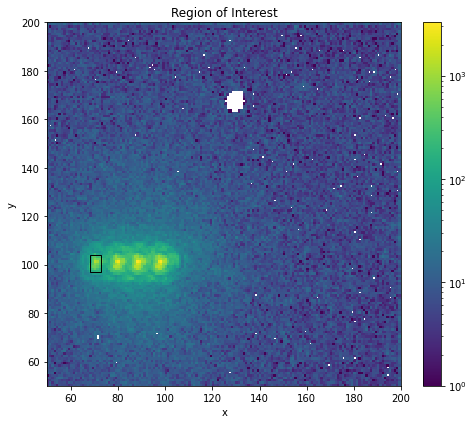

In [ ]:
OneIon = Ion(68, 97, 73, 104, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

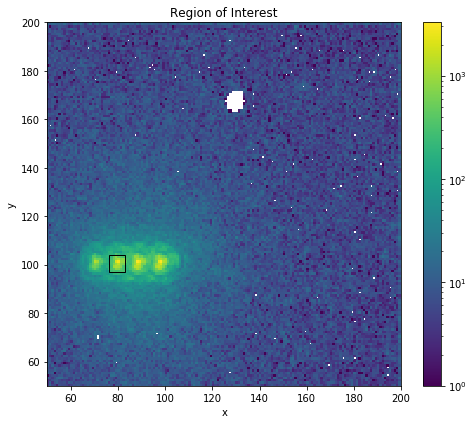

Averages: [2810026.68600643 1965737.36376779 2879396.24363328 4164155.8929295
 1453379.07471056] 

Standard Deviation with No Alteration: 6652940.705810134 

Average (unaltered) 2108506.536650489 



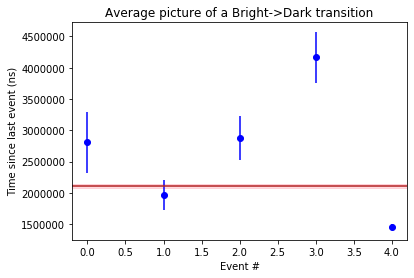

Averages: [1051400.20727041 1023369.23680905 1083518.79121703 1346596.38120767
 1260133.4834381 ] 

Standard Deviation of Bright State Transition Times w/o outliers: 886221.9865296718 

Average (no outliers) 1003175.877443799 



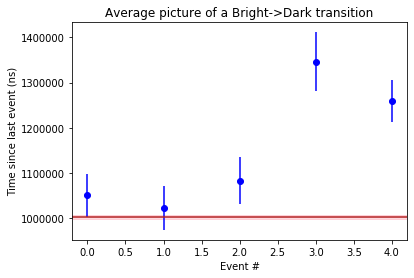

Averages: [789475.99191712 744740.38985475 776426.9210084  719020.82073955
 915584.6614508 ] 

Standard Deviation w Ceiling: 739490.3315703479 

Average (ceiling) 894526.8485655297 



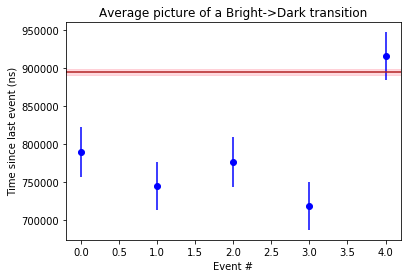

In [17]:
OneIon = Ion(76, 97, 83, 104, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

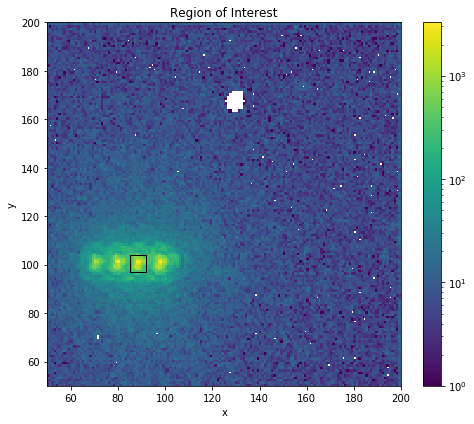

Averages: [2251080.92343248 4145418.25389466 3625492.58940289 8019524.22059693
 1781290.83638026] 

Standard Deviation with No Alteration: 6495563.338429071 

Average (unaltered) 1630555.1834673313 



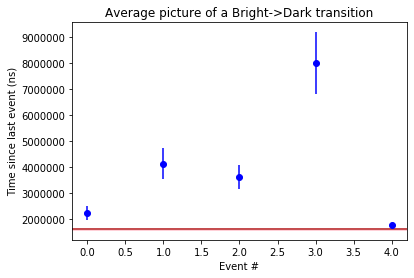

Averages: [1212268.91686893 1405382.31307078 1623903.36345382 2341078.64046392
 1637817.65436747] 

Standard Deviation of Bright State Transition Times w/o outliers: 763072.3120098254 

Average (no outliers) 872894.4114842087 



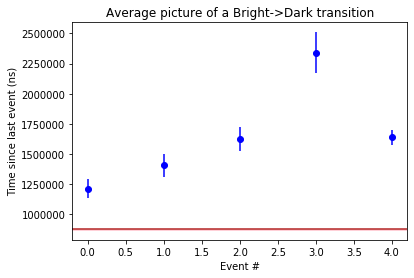

Averages: [ 744023.6484375   716206.55268595  743534.97109375  623259.96601382
 1010210.13448355] 

Standard Deviation w Ceiling: 716119.7649512368 

Average (ceiling) 839032.3950916973 



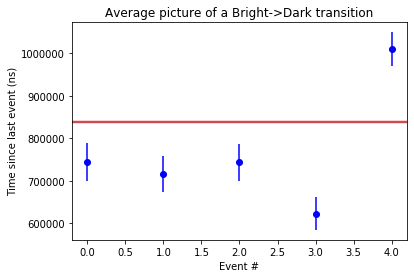

In [18]:
OneIon = Ion(85, 97, 92, 104, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

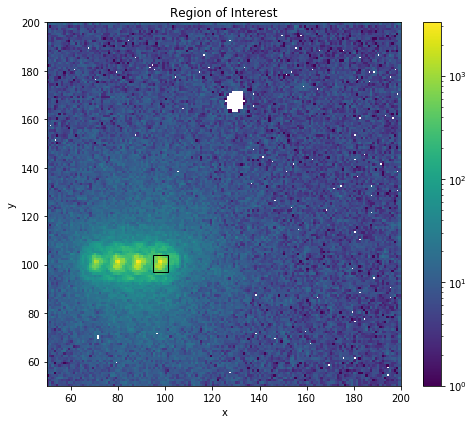

Averages: [2130475.390625   3036508.67513021 2605061.91860465 8191983.66210938
 1787469.45478723] 

Standard Deviation with No Alteration: 8214399.681982405 

Average (unaltered) 1565570.903154738 



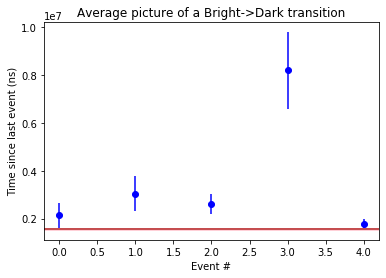

Averages: [1040761.40391791 1298121.875      1530767.63139205 2026336.81722689
 1555611.99259021] 

Standard Deviation of Bright State Transition Times w/o outliers: 855930.0666046742 

Average (no outliers) 1001941.3111150911 



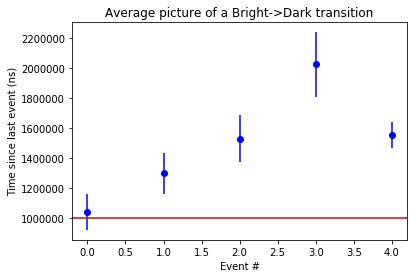

Averages: [ 621774.65765766  745082.41346154  673452.60689655  723524.31795058
 1066037.73643617] 

Standard Deviation w Ceiling: 747646.301627764 

Average (ceiling) 918450.4581238423 



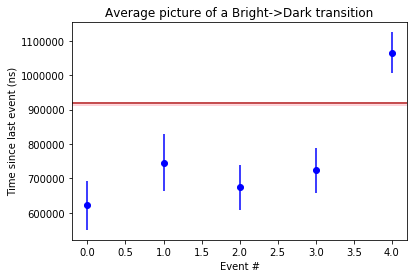

In [19]:
OneIon = Ion(95, 97, 101, 104, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

### Three Ion Set 1

In [20]:
# Retrieving data from csv file
file = "Research/REU/TwoIonsTelegraf_100s_W0028_H11-200211-004225-1_cent.csv"

data = np.genfromtxt(file, delimiter=",", usecols=[0,1,2,3,4,5], names=True)
# col/row are just xy positional data?
y = data['Col']
x = data['Row']

ToA = data['ToA']
ToTarb = data['ToTarb']
ToTtotalarb = data['ToTtotalarb']
centroid = data['Centroid']

In [21]:
tof = []
for i in range(len(x)):
    tof.append(ToA[i]/4096.*25.)

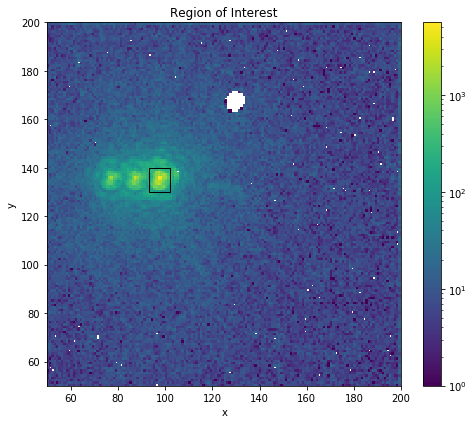

Averages: [2675862.27229899 2529123.90625    1855981.49601064 6381007.20909553
 1424752.94084821] 

Standard Deviation with No Alteration: 4772913.029757657 

Average (unaltered) 949410.6271582934 



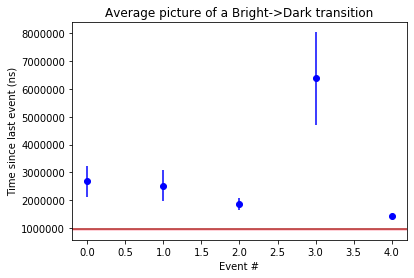

Averages: [ 683529.43262411  859053.07326159 1113056.88590116 1768707.47096995
 1224503.60743088] 

Standard Deviation of Bright State Transition Times w/o outliers: 515666.9552759725 

Average (no outliers) 599021.9524842452 



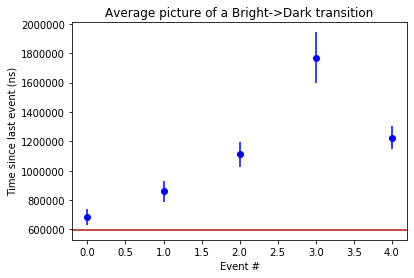

Averages: [595341.03963415 639714.58237327 755518.86770833 581378.49
 946707.52611607] 

Standard Deviation w Ceiling: 613003.6832021185 

Average (ceiling) 661977.8303915388 



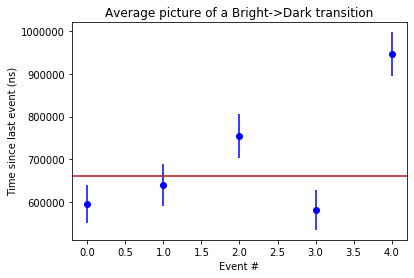

In [22]:
OneIon = Ion(93, 130, 102, 140, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

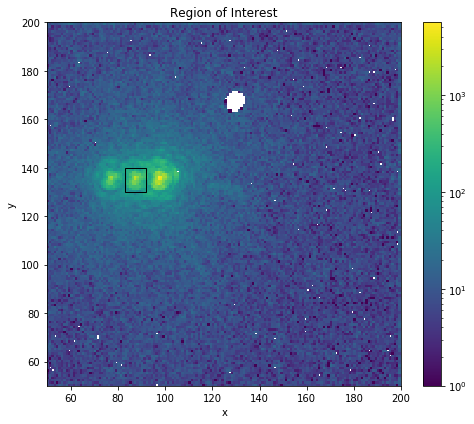

Averages: [3222917.42154536 3597829.67313879 3788718.90120968 5248545.79245602
 1707467.4934681 ] 

Standard Deviation with No Alteration: 6057789.248935203 

Average (unaltered) 1717446.2211327723 



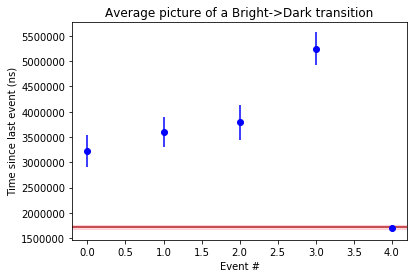

Averages: [1429720.41973039 1731027.62784091 1890677.4609375  2897891.93300189
 1547740.14371418] 

Standard Deviation of Bright State Transition Times w/o outliers: 611754.4367513342 

Average (no outliers) 666124.4963839084 



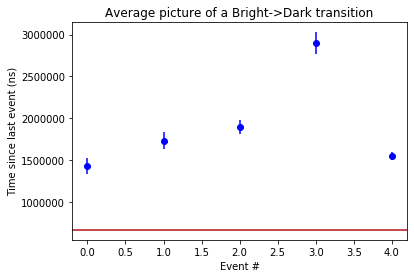

Averages: [665285.09643555 607059.49213362 696877.53527778 614401.36483135
 905041.01629538] 

Standard Deviation w Ceiling: 642991.28608144 

Average (ceiling) 685374.0976008215 



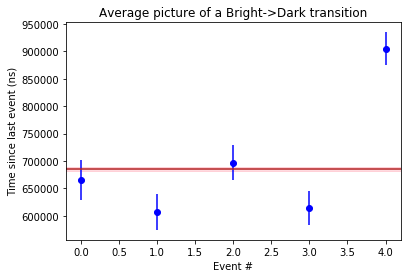

In [23]:
OneIon = Ion(83, 130, 92, 140, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

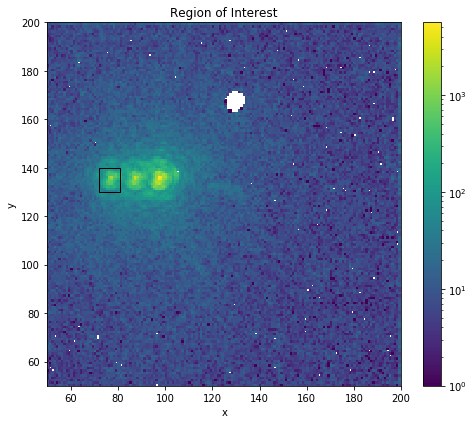

Averages: [3053395.94002695 3392757.49703088 3683897.41623711 5050110.45500449
 1587698.42655812] 

Standard Deviation with No Alteration: 7850921.9626394035 

Average (unaltered) 2623171.152779342 



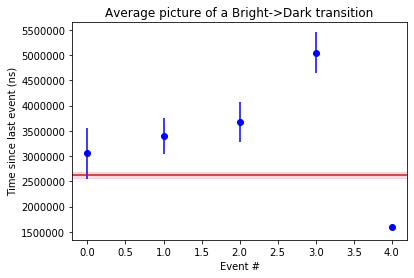

Averages: [ 947710.42520492 1060520.86538462 1222531.10017123 1596748.78090659
 1398984.69889635] 

Standard Deviation of Bright State Transition Times w/o outliers: 784136.7913312807 

Average (no outliers) 835115.7167117846 



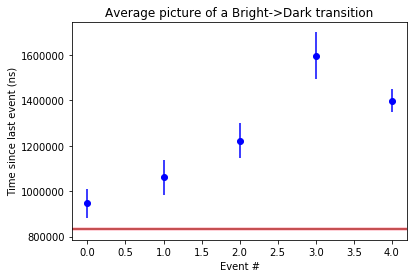

Averages: [608198.39660138 551185.5893595  678075.74193548 601534.8418302
 959547.55821078] 

Standard Deviation w Ceiling: 693055.0604099227 

Average (ceiling) 775736.6703647318 



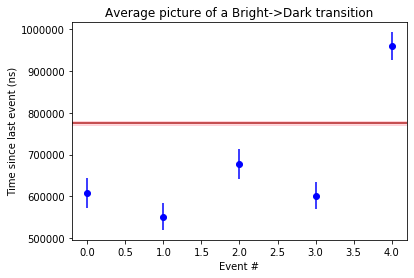

In [24]:
OneIon = Ion(72, 130, 81, 140, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

### Four Ion Set 2

In [59]:
# Retrieving data from csv file
file = "Research/REU/FourIonsTelegraf_100s_W0028_H11-200211-012646-1_cent.csv"

data = np.genfromtxt(file, delimiter=",", usecols=[0,1,2,3,4,5], names=True)
# col/row are just xy positional data?
y = data['Col']
x = data['Row']

ToA = data['ToA']
ToTarb = data['ToTarb']
ToTtotalarb = data['ToTtotalarb']
centroid = data['Centroid']

In [60]:
tof = []
for i in range(len(x)):
    tof.append(ToA[i]/4096.*25.)

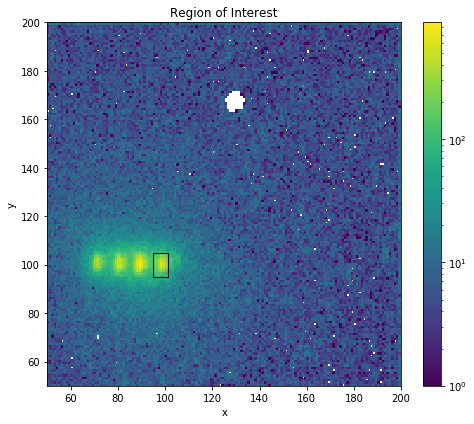

Averages: [4809564.17910448 3591297.71205357 4531548.26536017 8816205.75181159
 1828384.47115385] 

Standard Deviation with No Alteration: 8659330.362656586 

Average (unaltered) 1716759.2433836698 



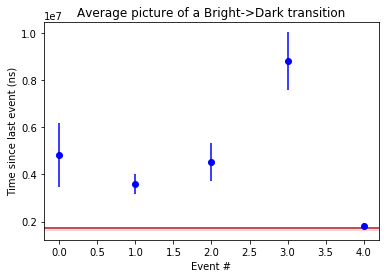

Averages: [1605403.08866279 3097816.796875   1959231.62109375 4280356.875
 1651904.67754777] 

Standard Deviation of Bright State Transition Times w/o outliers: 710476.1290960776 

Average (no outliers) 812534.9351961729 



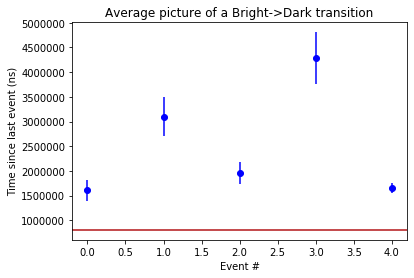

Averages: [620517.73641304 519309.16363636 613194.4274635  488601.81944444
 960915.49487179] 

Standard Deviation w Ceiling: 691950.5000973479 

Average (ceiling) 799693.60291101 



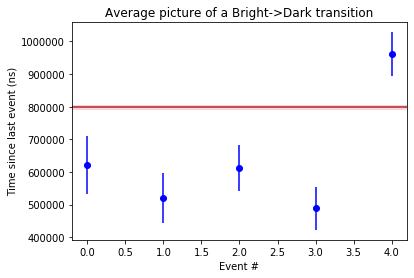

In [61]:
OneIon = Ion(95, 95, 101, 105, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

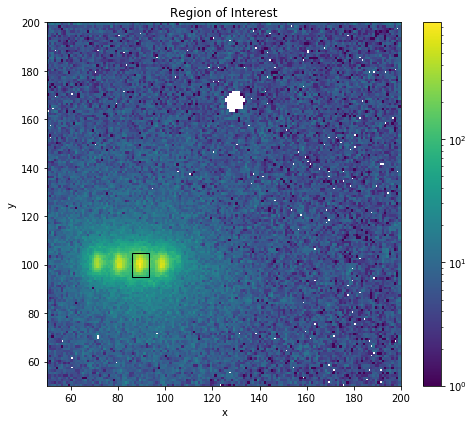

Averages: [2177156.41121032 4122108.89163669 4297877.56102071 6775891.96068548
 1727097.2002551 ] 

Standard Deviation with No Alteration: 9047738.544552064 

Average (unaltered) 1417128.3916432254 



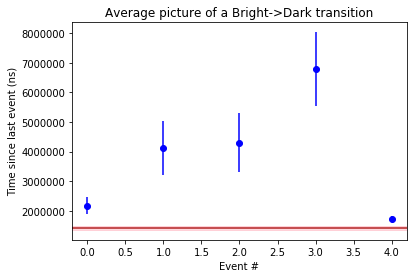

Averages: [1402182.14798851 1440927.46975806 1562548.85232301 1888861.37019231
 1481035.71428571] 

Standard Deviation of Bright State Transition Times w/o outliers: 574888.0538752553 

Average (no outliers) 658131.7401158399 



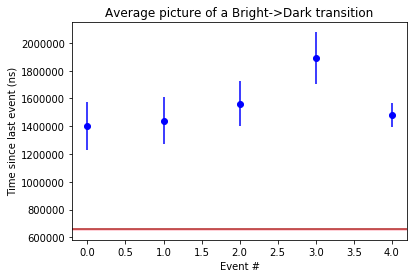

Averages: [ 518825.72804054  533137.80898437  639253.55978261  538851.45854271
 1001944.72193878] 

Standard Deviation w Ceiling: 639424.7589786206 

Average (ceiling) 700173.1909071287 



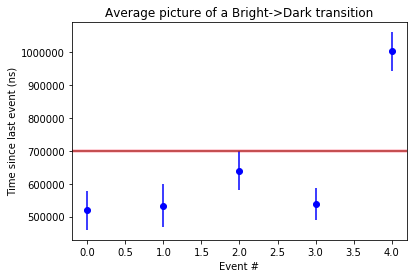

In [62]:
OneIon = Ion(86, 95, 93, 105, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

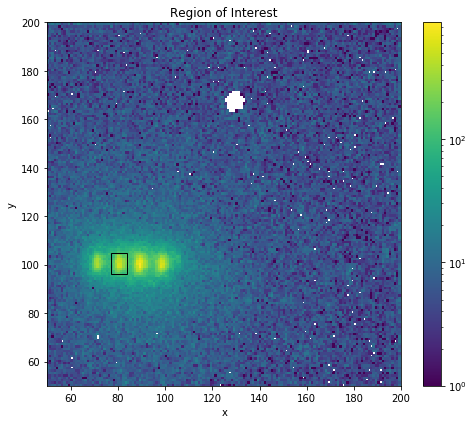

Averages: [1865923.12985751 3227733.52134146 1969740.81521739 7370190.325
 1863119.86391129] 

Standard Deviation with No Alteration: 9593145.095260587 

Average (unaltered) 2058826.5198422957 



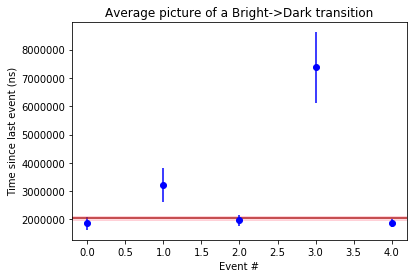

Averages: [ 882425.55717054 1082558.73161765  991784.81841216 1576823.76302083
 1537062.32182018] 

Standard Deviation of Bright State Transition Times w/o outliers: 694775.9797196324 

Average (no outliers) 779509.6547235895 



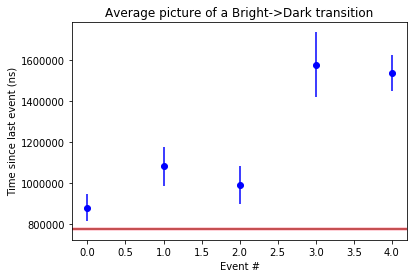

Averages: [720349.83488372 633267.35166667 669952.15015244 533304.26383588
 869356.02842742] 

Standard Deviation w Ceiling: 673085.5305092426 

Average (ceiling) 765299.4297619048 



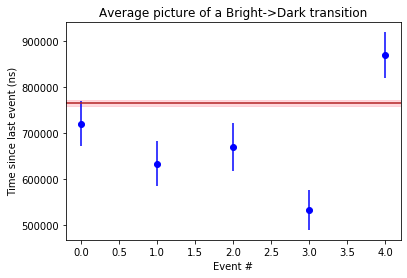

In [63]:
OneIon = Ion(77, 96, 84, 105, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

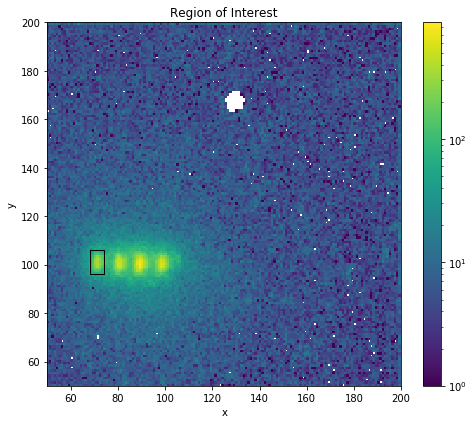

Averages: [2029431.7139738  2447780.03989362 2943882.41383745 4574475.23991142
 1550562.27756076] 

Standard Deviation with No Alteration: 13386095.127228627 

Average (unaltered) 3303747.8847444355 



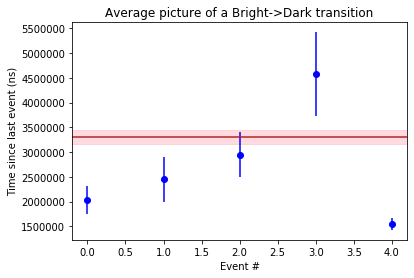

Averages: [1129775.77097039 1088189.16266026 1241165.48913043 1441660.72733918
 1311337.29420732] 

Standard Deviation of Bright State Transition Times w/o outliers: 1132602.5836672203 

Average (no outliers) 1235572.2077922078 



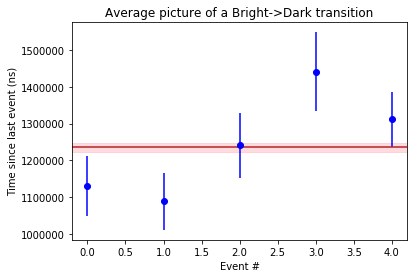

Averages: [819467.54936975 738665.344393   796919.7595     722431.84459459
 981655.76866319] 

Standard Deviation w Ceiling: 775771.7230565638 

Average (ceiling) 963021.4742822966 



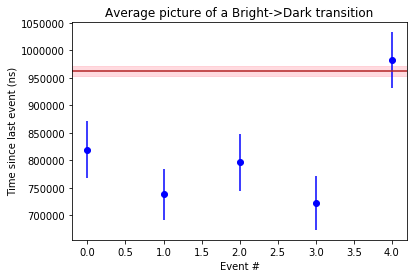

In [64]:
OneIon = Ion(68, 96, 74, 106, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

### Four Ion Set 3

In [65]:
# Retrieving data from csv file
file = "Research/REU/FourIonsTelegraf_100s_W0028_H11-200211-013412-1_cent.csv"

data = np.genfromtxt(file, delimiter=",", usecols=[0,1,2,3,4,5], names=True)
# col/row are just xy positional data?
y = data['Col']
x = data['Row']

ToA = data['ToA']
ToTarb = data['ToTarb']
ToTtotalarb = data['ToTtotalarb']
centroid = data['Centroid']

tof = []
for i in range(len(x)):
    tof.append(ToA[i]/4096.*25.)

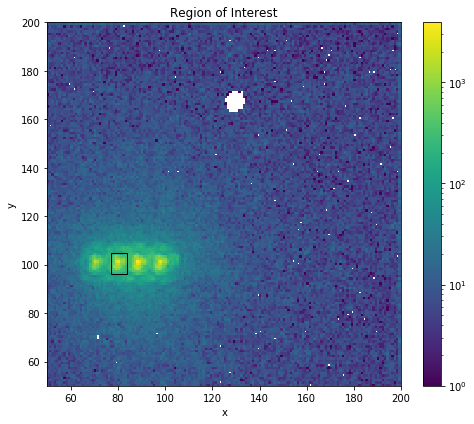

Averages: [1536087.40469039 2356671.23893805 2687599.81496711 4599947.17112866
 1524548.00275482] 

Standard Deviation with No Alteration: 6185073.4666024465 

Average (unaltered) 1822204.7300589853 



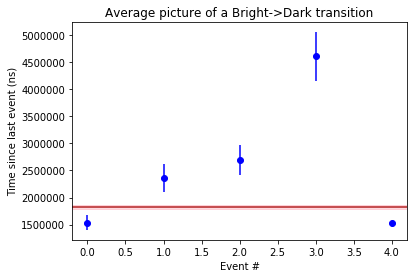

Averages: [ 827886.30514706  948587.31233681 1076828.81050858 1474110.61038419
 1320962.15838878] 

Standard Deviation of Bright State Transition Times w/o outliers: 763799.6909828517 

Average (no outliers) 858865.7329672761 



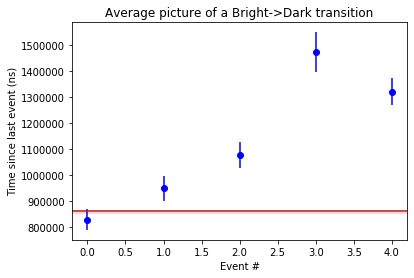

Averages: [707860.08529946 697706.68268389 802331.4098127  697172.13544862
 910795.96461777] 

Standard Deviation w Ceiling: 708763.6215324785 

Average (ceiling) 820316.1838580628 



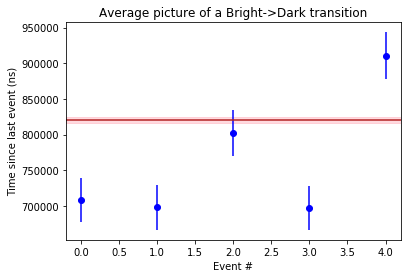

In [66]:
OneIon = Ion(77, 96, 84, 105, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

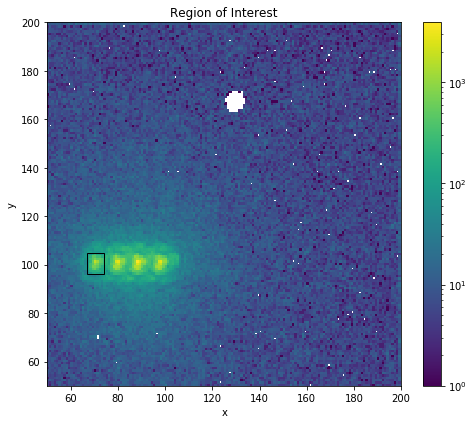

Averages: [2949028.04567308 2768409.39346381 2794381.77884615 3241428.8067805
 1487497.52033792] 

Standard Deviation with No Alteration: 8727258.119581454 

Average (unaltered) 3424937.9982562494 



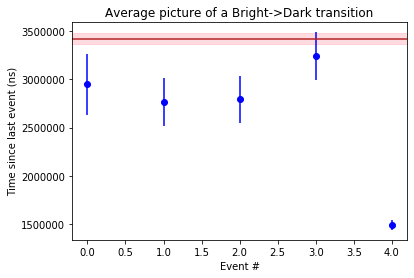

Averages: [1226597.37611359 1414784.44782839 1386950.3813244  1637582.39813536
 1478681.76817602] 

Standard Deviation of Bright State Transition Times w/o outliers: 1302443.355154634 

Average (no outliers) 1420456.387757819 



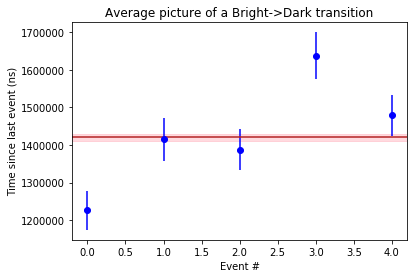

Averages: [782021.21591782 842583.29314159 819891.56363478 802631.22902851
 867523.6637985 ] 

Standard Deviation w Ceiling: 791750.8735835714 

Average (ceiling) 1016069.794380315 



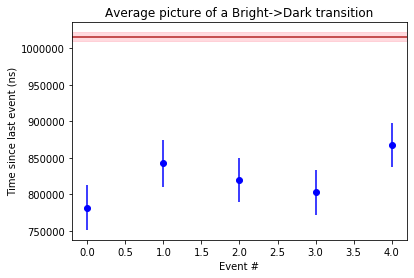

In [67]:
OneIon = Ion(67, 96, 74, 105, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

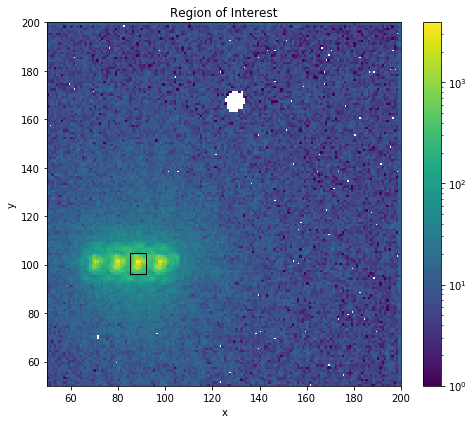

Averages: [3025990.76469371 2891551.52064732 4554438.21060505 5792396.0577477
 1627815.24906015] 

Standard Deviation with No Alteration: 5758384.185350551 

Average (unaltered) 1385217.6319305669 



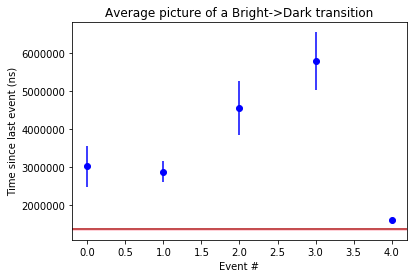

Averages: [1257779.23209799 1218685.21358945 1553266.61184211 1978659.99487705
 1499242.28830645] 

Standard Deviation of Bright State Transition Times w/o outliers: 639233.8664971332 

Average (no outliers) 735544.9661316284 



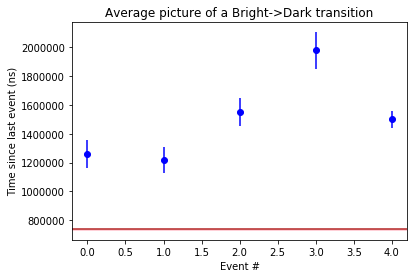

Averages: [616019.64931611 668500.5689415  724671.64551768 662584.52721088
 946104.06273496] 

Standard Deviation w Ceiling: 672008.1148341359 

Average (ceiling) 757705.8762625005 



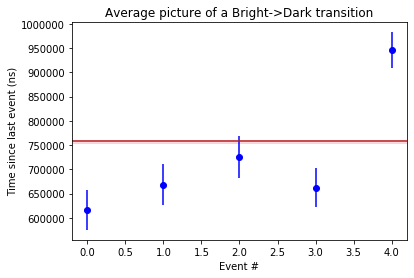

In [68]:
OneIon = Ion(85, 96, 92, 105, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

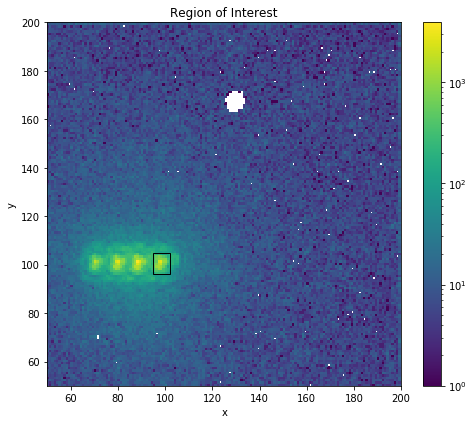

Averages: [5283940.61011905 3997402.35020661 4797163.11703822 7871550.93283582
 1820442.25127551] 

Standard Deviation with No Alteration: 6594333.977837296 

Average (unaltered) 1399733.559487553 



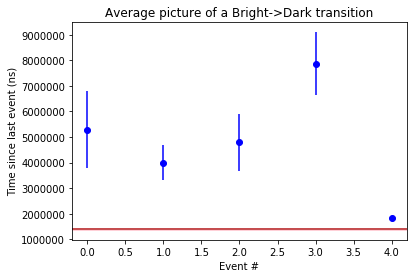

Averages: [1354786.875      1721864.38802083 1636280.92447917 2752445.03147482
 1598545.00269397] 

Standard Deviation of Bright State Transition Times w/o outliers: 742189.4348498005 

Average (no outliers) 857848.826016363 



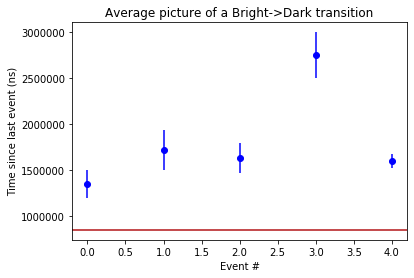

Averages: [ 658073.02403846  590780.33413462  649503.88077446  608486.4478211
 1180252.12627551] 

Standard Deviation w Ceiling: 714679.3615433169 

Average (ceiling) 837750.1058983942 



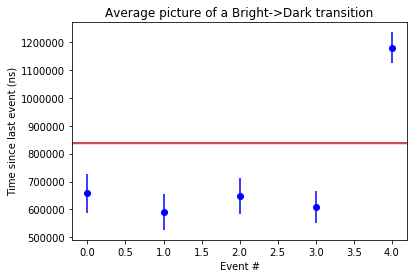

In [69]:
OneIon = Ion(95, 96, 102, 105, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

### Four Ion Set 4

In [70]:
# Retrieving data from csv file
file = "Research/REU/FourIonsTelegraf_300s_W0028_H11-200211-013824-1_cent.csv"

data = np.genfromtxt(file, delimiter=",", usecols=[0,1,2,3,4,5], names=True)
# col/row are just xy positional data?
y = data['Col']
x = data['Row']

ToA = data['ToA']
ToTarb = data['ToTarb']
ToTtotalarb = data['ToTtotalarb']
centroid = data['Centroid']

tof = []
for i in range(len(x)):
    tof.append(ToA[i]/4096.*25.)

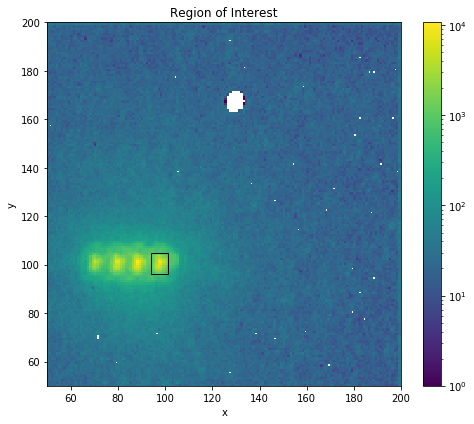

Averages: [3479246.61458333 5194425.42076055 3895127.20430929 6451565.86244687
 1843487.60694908] 

Standard Deviation with No Alteration: 5246859.543272275 

Average (unaltered) 1103394.5812317263 



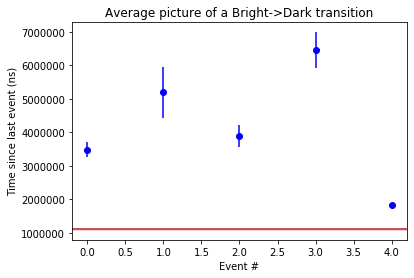

Averages: [1958529.03333333 2188189.07667234 2085377.94184982 3224028.86304185
 1713598.91839903] 

Standard Deviation of Bright State Transition Times w/o outliers: 570293.5063310439 

Average (no outliers) 656215.9245353311 



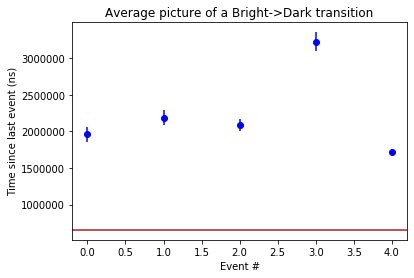

Averages: [ 698925.9912594   685032.22486684  767154.81920415  655412.06205403
 1045475.34231651] 

Standard Deviation w Ceiling: 640762.484272046 

Average (ceiling) 702435.9652118181 



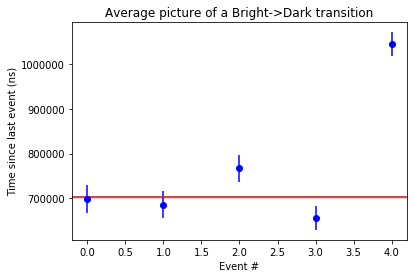

In [71]:
OneIon = Ion(94, 96, 101, 105, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

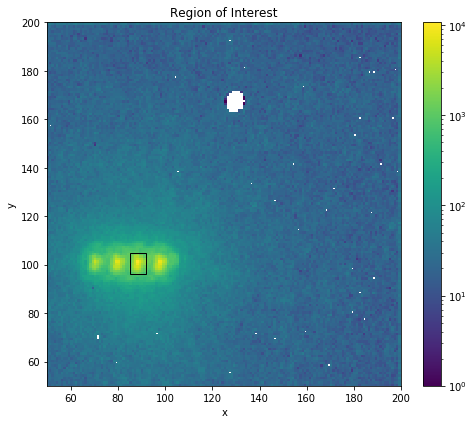

Averages: [2667503.05824978 3555523.009013   3725689.46803435 5562009.31114551
 1695700.46212513] 

Standard Deviation with No Alteration: 4817718.485949328 

Average (unaltered) 1131809.2313179676 



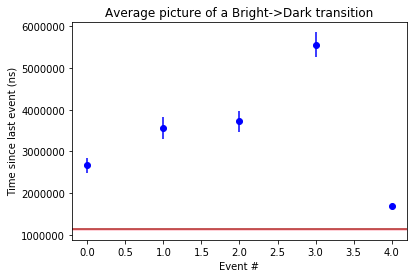

Averages: [1271307.54867474 1549532.27516139 1679998.88189524 2652241.19244837
 1576059.52481431] 

Standard Deviation of Bright State Transition Times w/o outliers: 507522.6105736918 

Average (no outliers) 577479.1299639458 



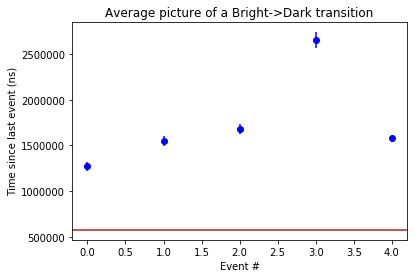

Averages: [690361.61573492 692449.09382097 737781.53405638 665266.8998709
 988337.61931231] 

Standard Deviation w Ceiling: 599452.016082374 

Average (ceiling) 634075.5899826565 



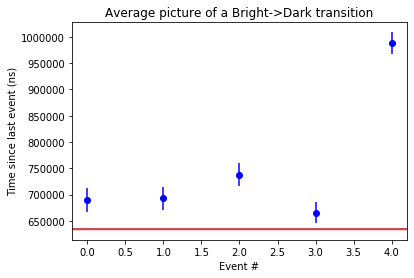

In [72]:
OneIon = Ion(85, 96, 92, 105, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

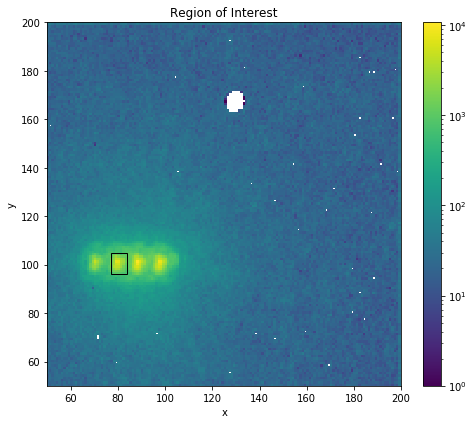

Averages: [1921448.22025401 2200058.41050486 2238073.54856624 4097635.02722898
 1527844.24761146] 

Standard Deviation with No Alteration: 5131376.320338603 

Average (unaltered) 1441796.3029009567 



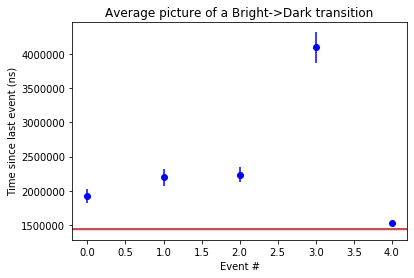

Averages: [ 793943.6501204   911592.41147611 1000831.09563253 1417454.46608847
 1333129.7505517 ] 

Standard Deviation of Bright State Transition Times w/o outliers: 596025.9171182064 

Average (no outliers) 666845.8099860442 



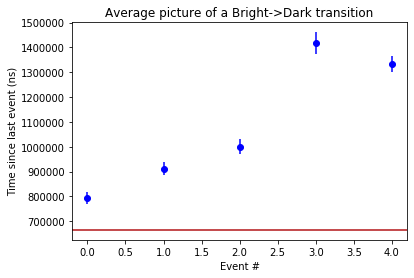

Averages: [681829.22508027 697744.14637142 700006.81735889 674352.05681247
 924300.92123521] 

Standard Deviation w Ceiling: 645690.8349820382 

Average (ceiling) 698476.6590401407 



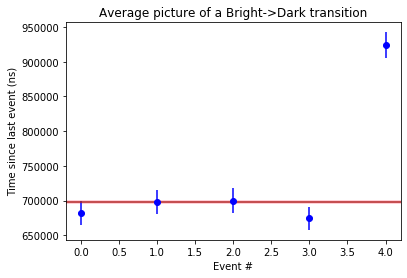

In [73]:
OneIon = Ion(77, 96, 84, 105, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

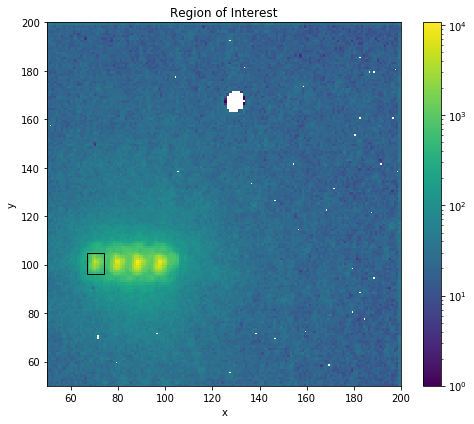

Averages: [2277557.41845596 2704513.58103198 2653181.217365   3619747.1523533
 1428245.99542334] 

Standard Deviation with No Alteration: 7217109.356897359 

Average (unaltered) 2687560.412622255 



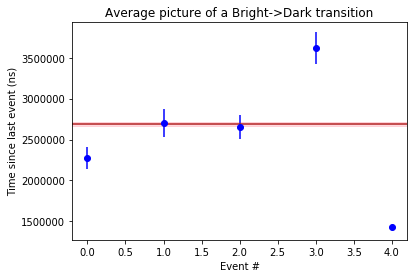

Averages: [1054154.28373667 1119281.96237093 1169948.74284351 1275938.65078294
 1266217.71684925] 

Standard Deviation of Bright State Transition Times w/o outliers: 1024959.7817446177 

Average (no outliers) 1107618.0214771708 



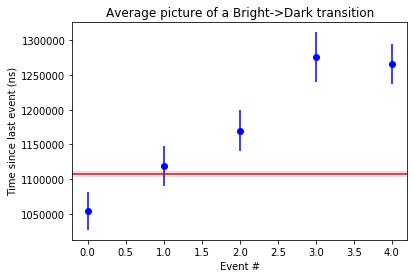

Averages: [789126.82752992 786478.09636101 803682.99540208 714254.78243902
 887315.40712243] 

Standard Deviation w Ceiling: 751480.6558954079 

Average (ceiling) 908042.2408855965 



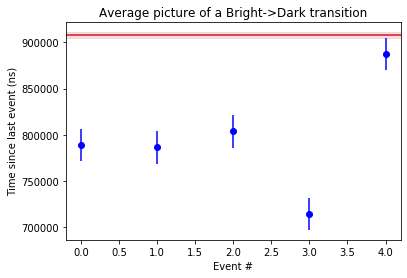

In [74]:
OneIon = Ion(67, 96, 74, 105, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

### Two Ion Set 2

In [75]:
# Retrieving data from csv file
file = "Research/REU/TwoIonsTelegraf_100s_W0028_H11-200211-004439-1_cent.csv"

data = np.genfromtxt(file, delimiter=",", usecols=[0,1,2,3,4,5], names=True)
# col/row are just xy positional data?
y = data['Col']
x = data['Row']

ToA = data['ToA']
ToTarb = data['ToTarb']
ToTtotalarb = data['ToTtotalarb']
centroid = data['Centroid']

tof = []
for i in range(len(x)):
    tof.append(ToA[i]/4096.*25.)

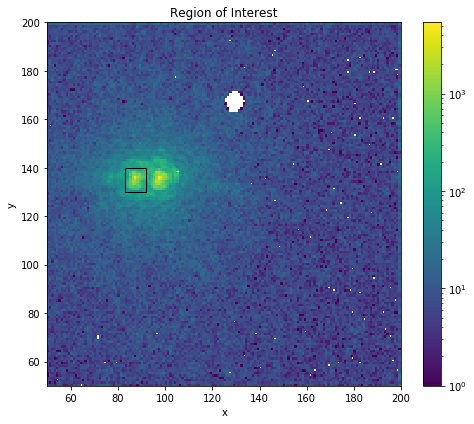

Averages: [2567294.5625     2519331.74119241 2596254.83908582 4979653.93806561
 1513789.0625    ] 

Standard Deviation with No Alteration: 6448415.177546075 

Average (unaltered) 1311763.8942896305 



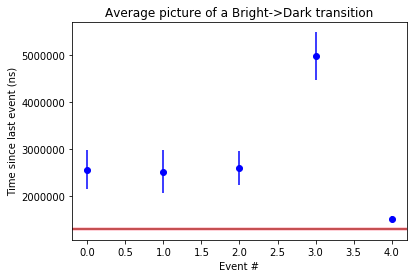

Averages: [ 633522.20158811  648352.22858566  772457.63888889 1682157.90322581
 1312817.07729849] 

Standard Deviation of Bright State Transition Times w/o outliers: 498861.64277298556 

Average (no outliers) 570989.8412758743 



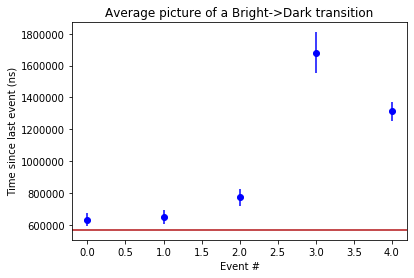

Averages: [581999.78790431 526960.25562339 641669.89683014 563018.35016556
 908333.58175803] 

Standard Deviation w Ceiling: 590308.0659678157 

Average (ceiling) 626644.3823077823 



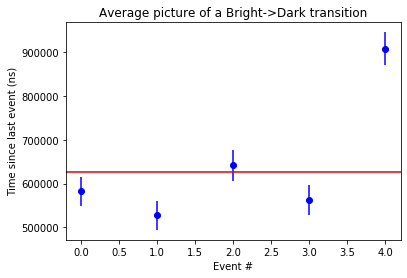

In [76]:
OneIon = Ion(83, 130, 92, 140, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)

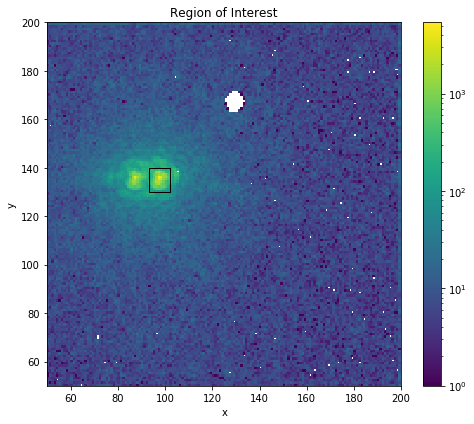

Averages: [2714320.17663043 2813909.09722222 3319132.56540698 9028606.21837045
 1512499.54160095] 

Standard Deviation with No Alteration: 4536419.736415053 

Average (unaltered) 932502.7112938407 



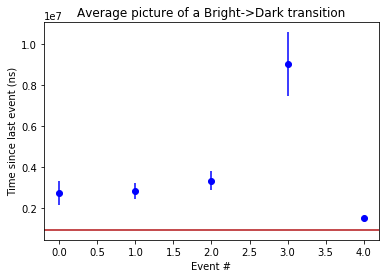

Averages: [ 930426.49016204  966159.58686441 1227977.01870438 1794004.06804734
 1337381.2042364 ] 

Standard Deviation of Bright State Transition Times w/o outliers: 481901.7235281952 

Average (no outliers) 558324.1110893567 



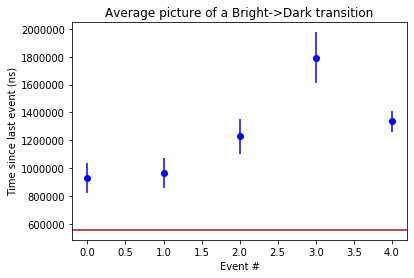

Averages: [526308.26722973 618481.52818627 594322.90783898 597768.05673077
 980433.2898265 ] 

Standard Deviation w Ceiling: 588490.9823978657 

Average (ceiling) 624537.8031111333 



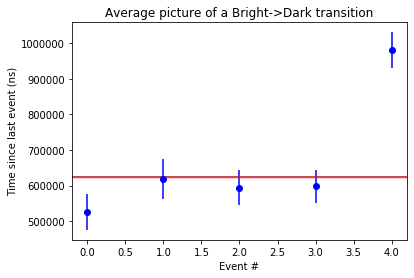

In [77]:
OneIon = Ion(93, 130, 102, 140, x, y, tof, 5e6, 2, 3e6)

OneIon.comboSorting(x,y,tof)
OneIon.transitions()

OneIon.leadup(setthresh=False, showdark=False, outliers=True)
OneIon.leadup(setthresh=False, showdark=False, outliers=False)

OneIon.dTimes()
OneIon.transitions()
OneIon.leadup(setthresh=True, showdark=False, outliers=True)